# Maze Navigation 

In this simple meta-learning task, the agent is placed at the center of a maze of odd dimensions. The goal of the agent is to get to a reward cell which is randomly selected in the beginning of each episode.


**Google Drive Set-up:**


In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# project folder, e.g. 'project submissions/A09_A10_A54'
# $$ for us - 'DSc Term Project/'
FOLDERNAME = 'DSc Term Project/Task 2'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# test - this notebooks name should show up:
# is oserror - restart runtime
%cd /content/drive/My\ Drive/$FOLDERNAME
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1khPuOHY9jnXOARox2UYYUJ3TRirri2cS/DSc Term Project/Task 2
'Maze Task.ipynb'   NM.ipynb   NP.ipynb   RM.ipynb   saved/   SM.ipynb   utils/


**Import Statements:**


In [0]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from torch.optim import lr_scheduler

import numpy as np
import time
import pickle
import random
from tqdm.autonotebook import tqdm
#from graphics import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots



np.set_printoptions(precision=4)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

**GPU Set-up:**

You have an option to use GPU by setting the flag to `True` below.

The global variables `dtype` and `device` will control the data types throughout this notebook. 

You need to manually switch to a GPU device. You can do this by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`. Note that you have to rerun the cells from the top since the kernel gets restarted upon switching runtimes.

In [3]:
# flag
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.float32
else:
    device = torch.device('cpu')
    dtype = torch.float32

print('Using Device:', device)

Using Device: cuda


### Training

The cells in this section define utility functions required by the `train()` function, which is given in the last cell.

**Creating Networks:**

We will use 4 different types of recurrent neural networks (RNNs) to show the effect of modulation and plasticity on the accumulated reward in this task. These are defined in `utils/networks.py`. In our experiments we will analyse the following RNNs:
1. Non-Plastic, Non-Modulated  `NP`
2. Plastic, Non-Modulated `NM`
3. Plastic, Simple Modulation `SM`
4. Plastic, Retro Modulation `RM`

We define a function `get_network()` that takes a dictionary `params` (defined later) holding the parameters required for the networks as well as a variable `type` dictating which of the RNNs is to be returned. It also migrates the model to the GPU, if available.


In [0]:
from utils.networks import *


def get_network():
    # determine which RNN to return
    net_type = params['net_type']
    if net_type == 'NP':
        RNN = NonPlastic_NonModulated_RNN(params)
    elif net_type == 'NM':
        RNN = Plastic_NonModulated_RNN(params)
    elif net_type == 'SM':
        RNN = Plastic_SimpleModulated_RNN(params)
    else:
        RNN = Plastic_RetroactiveModulated_RNN(params)

    # move to GPU and return, if possible
    RNN.to(device=device, dtype=dtype)
    return RNN
  

**Visualizations:**

We define a function `start_graphics()` to add visualizations so the activities performed in this task are better understood. We have used `utils/graphics.py`, a Python library developed by *Zelle*.


In [0]:
#from utils.graphics import *

def start_graphics(maze_grid):

    if params['visualise']:
      win = GraphWin('Maze', params['maze_size']*50, params['maze_size']*50) 
      win.setBackground("yellow")
      rectarray = np.empty(shape=(params['maze_size'],params['maze_size']),dtype='object')  
      for i in range(0,params['maze_size']):
    	  for j in range(0,params['maze_size']):
		      aRectangle = Rectangle(Point(i*50,j*50), Point(50+i*50,j*50+50))
		      if maze_grid[i,j]==1:
		    	  aRectangle.setFill("blue")
		      aRectangle.draw(win)
		      rectarray[i,j]=(aRectangle)
      
      return win, rectarray
    
    else:
      return None

  

#start_graphics()

**Other Utility Functions:**

Here we define some additional helper functions that help us keep our code oragnised in this notebook, and reduce the LOC in the `train()` function


In [0]:
# returns a dictionary of blank lists corresponding to the statistics
# over all episodes we wish to track in our experiments
def get_blank_statistics_dict():
    all_stats = {
        'losses' : [],
        'grad_norms' : [],
        'losses_objective' : [],
        'total_rewards' : [],
        'losses_v' : [],
        'mean_reward' : [],
        'total_rewards_batchwise' : []

    }
    return all_stats


# called at the start of each episode to individually reset the values of 
# hebb, prev, E, and plastic_weights (check architechture for more details)
# note: none of these require grads since we manually update them
def initial_zero_BH(): # used to reset prev hidden state (BxH)
    return Variable(torch.zeros(params['batch_size'], params['hidden_size']), 
                    requires_grad=False).to(device, dtype)

def initial_zero_BHH(): # used to reset E (eligibility trace), plastic_weights, and hebb
    return Variable(torch.zeros(params['batch_size'], params['hidden_size'], params['hidden_size']), 
                    requires_grad=False).to(device, dtype) # (BxHxH)



**Training Function:**

This is the main function we've used to train the network and analyze it's response over all episodes and for all batches. 


### Vectorized Train
This is the main part of the code where we train the network

In [0]:
def vectorized_train():
    # print current parameters as a check - global variables
    print(params)

    # set random seeds for training, so that results are comparable
    np.random.seed(params['rng_seed'])
    random.seed(params['rng_seed'])
    torch.manual_seed(params['rng_seed'])

    # create the network required determined by params['net_type']
    net = get_network()

    # initialise optimiser - we use Adam with L2 reg
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=params['learning_rate'], 
                                 weight_decay=params['lambd'])
    

    if params['saved_already'] == False:
      # create dictionary to keep track of stats over all episodes
      all_stats = get_blank_statistics_dict()
      epoch=0
    else:
      checkpoint_path = 'saved/Checkpoint' + params['net_type'] + '.pt'
      checkpoint = torch.load(checkpoint_path)
      print('Loading states 1')
      print(net.load_state_dict(checkpoint['state_dict']))
      print('Loading states 2')
      print(optimizer.load_state_dict(checkpoint['optimizer']))
      epoch = checkpoint['iters'] + 1
      all_stats=checkpoint['stats_dict'] 
      print(f"Loaded from '{checkpoint_path}' at episode {epoch}")
    
    lossbetweensaves = 0
    nowtime = time.time()


    
    # Creating the maze 
    BATCHSIZE = params['batch_size']

    maze_grid = np.ones((params['maze_size'], params['maze_size']))
    CTR = params['maze_size'] // 2


    # Creating the maze 
    maze_grid[1:params['maze_size']-1, 1:params['maze_size']-1].fill(0)
    for row in range(1, params['maze_size'] - 1):
        for col in range(1, params['maze_size'] - 1):
            if row % 2 == 0 and col % 2 == 0:
                maze_grid[row, col] = 1

    maze_grid[CTR,CTR] = 0

    # Graphics 
    if params['visualise']:
      rectarray, win= start_graphics(maze_grid)
    # loop over every episode:
    for numiter in tqdm(range(epoch, params['num_episodes'])): 

        posr = {}; posc = {}
        rposr = {}; rposc = {}


        # Re initializing Graphics

        if params['visualise']:

          for i in range(0,params['maze_size']):
              for j in range(0,params['maze_size']):
                  aRectangle = Rectangle(Point(i*50,j*50), Point(50+i*50,j*50+50))
                  if maze_grid[i,j]==1:
                      aRectangle.setFill("blue")
                  else:
                      aRectangle.setFill("yellow")
                  aRectangle.draw(win)
                  rectarray[i,j]=(aRectangle)



        # we zero out these values before each episode according to their lifetime
        # cache holds the extra inputs and outputs needed according to different network types 
        # initially cache is a list, then we convert it to a tuple

        prev = initial_zero_BH()
        cache = [prev]
        if params['net_type'] != 'NP':  # hebb is only for plastic
            hebb = initial_zero_BHH()
            cache.append(hebb)
        if params['net_type'] == 'RM':  # these are only for retroactive modulated
            E_t = initial_zero_BHH()              
            plastic_weights = initial_zero_BHH()
            cache.append(E_t)
            cache.append(plastic_weights)
        cache = tuple(cache)




        for nb in range(BATCHSIZE):  # Initialize reward for each batch 
            # Note: it doesn't matter if the reward is on the center (see below). All we need != to put it on a wall or pillar (lab=1)
            myrposr = 0; myrposc = 0
            
            while maze_grid[myrposr, myrposc] == 1 or (myrposr == CTR and myrposc == CTR):
                myrposr = np.random.randint(1, params['maze_size'] - 1)
                myrposc = np.random.randint(1, params['maze_size'] - 1)
            rposr[nb] = myrposr; rposc[nb] = myrposc

            #print("Reward pos:", myrposr, myrposc)
            # Agent always starts an episode from the center
            posc[nb] = CTR
            posr[nb] = CTR

            if nb==0 and params['visualise']:
                print("Marking reward position \n")
                print(rposr[0]," ", rposc[0])
                rectarray[rposr[0],rposc[0]].setFill("red") #Marking the reward
                rectarray[posr[0],posc[0]].setFill("black")

        # Make all gradients zero
        optimizer.zero_grad()
        
        
        # additional variables
        loss = 0                                    # loss is accumulated over the episode
        lossv = 0                                   # needed for A2C
        numactionchosen = 0                         # 0 -> not present, 1 -> present
        reward = np.zeros(params['batch_size'])     #
        sumreward = np.zeros(params['batch_size'])  #
        rewards = []                                #
        vs = []                                     # 
        logprobs = []                               # 
        dist = 0                                    #


        numactionschosen = np.zeros(params['batch_size'], dtype='int32')


        
        nbtrials = np.zeros(params['batch_size'])                     # Number of trials for each batch
        nbrewardabletrials = np.zeros(params['batch_size'])

        # loop over the trials in each episode
        for numstep in range(params['episode_length']): 
            

            inputs = np.zeros((params['batch_size'], params['input_size']), dtype='float32')

            labg = maze_grid.copy()    # Take a copy of the maze ? Why ?
            for nb in range(BATCHSIZE):     
                inputs[nb, 0:RFSIZE * RFSIZE] = labg[posr[nb] - RFSIZE//2:posr[nb] + RFSIZE//2 +1, posc[nb] - RFSIZE //2:posc[nb] + RFSIZE//2 +1].flatten() * 1.0

                # Previous chosen action
                inputs[nb, RFSIZE * RFSIZE +1] = 1.0 # Bias neuron
                inputs[nb, RFSIZE * RFSIZE +2] = numstep / params['episode_length']
                inputs[nb, RFSIZE * RFSIZE +3] = 1.0 * reward[nb]
                inputs[nb, RFSIZE * RFSIZE + ADDITIONAL_INPUTS + numactionschosen[nb]] = 1
            


            
            # create a tensor from the inputs and pass it into the network 
            inputsC = torch.from_numpy(inputs).to(device, dtype)
            inputs_tensor = Variable(inputsC, requires_grad=False)
            y, v, cache = net(inputs_tensor, cache)                        # y  should output raw scores, not probas

            # we apply softmax to get probabilities
            y = torch.softmax(y, dim=1)             

            # create distribution according to y and randomly choose an action accordingly
            distrib = torch.distributions.Categorical(y)
            actionschosen = distrib.sample()
            logprobs.append(distrib.log_prob(actionschosen))     # store log of proba

            numactionschosen = actionschosen.data.cpu().numpy()  # We want to break gradients
            reward = np.zeros(params['batch_size'], dtype='float32')

            # Auxiallary function to calculate rewards for each batch 
            for nb in range(BATCHSIZE):
                myreward = 0
                numactionchosen = numactionschosen[nb]       #Gives action chosen

                tgtposc = posc[nb]               #Position of column
                tgtposr = posr[nb]               #Position of Row
                if numactionchosen == 0:  # Up
                    tgtposr -= 1
                elif numactionchosen == 1:  # Down
                    tgtposr += 1
                elif numactionchosen == 2:  # Left
                    tgtposc -= 1
                elif numactionchosen == 3:  # Right
                    tgtposc += 1
                else:
                    raise ValueError("Wrong Action")

                reward[nb] = 0.0  # The reward for this step
                if maze_grid[tgtposr][tgtposc] == 1:
                    reward[nb] -= params['penalty']        #Penalty for hitting walls
                else:

                  if nb==0 and params['visualise']:

                	  rectarray[posr[0],posc[0]].setFill("yellow") ## Erasing previous position
                  
                  posc[nb] = tgtposc
                  posr[nb] = tgtposr

                  if nb==0 and params['visualise']:

                    rectarray[posr[0],posc[0]].setFill("black")  ## Setting new position of agent

                # Did we hit the reward location ? Increase reward and teleport!
                # Note that it doesn't matter if we teleport onto the reward, since reward hitting is only evaluated after the (obligatory) move...
                # But we still avoid it.
                if rposr[nb] == posr[nb] and rposc[nb] == posc[nb]: #We are at the reward location
                    reward[nb] += params['reward']
                    posr[nb]= np.random.randint(1, params['maze_size'] - 1)
                    posc[nb] = np.random.randint(1, params['maze_size'] - 1)     #Getting teleported
                    while maze_grid[posr[nb], posc[nb]] == 1 or (rposr[nb] == posr[nb] and rposc[nb] == posc[nb]):
                        posr[nb] = np.random.randint(1, params['maze_size'] - 1)
                        posc[nb] = np.random.randint(1, params['maze_size'] - 1)
                        
                    if nb==0 and params['visualise']:
                        #time.sleep(2)
                        rectarray[rposr[0],rposc[0]].setFill("red")
                        rectarray[posr[0],posc[0]].setFill("black")
                        #time.sleep(2)
            
            rewards.append(reward)
            # time.sleep(3)
            vs.append(v) 
            sumreward += reward

            # This is an "entropy penalty", implemented by the sum-of-squares of the probabilities 
            # The result is to encourage diversity in chosen actions.
            loss += ( params['entropy_reward_coeff'] * y.pow(2).sum() / params['batch_size'] )




        # Episode is done, now we do the actual computations of rewards and losses for the A2C algorithm
        R = torch.zeros(params['batch_size']).to(device)
        gammaR = params['reward_discount_factor']    #Discounting factor for rewards
        for numstepb in reversed(range(params['episode_length'])) :         # Every step in an episode has a reward
            R = gammaR * R + Variable(torch.from_numpy(rewards[numstepb]),requires_grad=False).to(device)
            ctrR = R - vs[numstepb][0]
            lossv += ctrR.pow(2).sum() / params['batch_size']
            loss -= (logprobs[numstepb] * ctrR.detach()).sum() / params['batch_size']



        loss += params['lossv_coeff'] * lossv      #Coefficient for value prediction loss
        loss /= params['episode_length']
        

        # perform backprop and gradient clipping
        loss.backward()
        all_stats['grad_norms'].append(torch.nn.utils.clip_grad_norm_(net.parameters(), params['gradient_clip']))
        if numiter > 100:  # Burn-in period for meanrewards
            optimizer.step()

        # update stats
        lossnum = float(loss)
        lossbetweensaves += lossnum
        all_stats['losses_objective'].append(lossnum)
        all_stats['total_rewards'].append(sumreward.mean())
        all_stats['total_rewards_batchwise'].append(sumreward)

        # Printitng statistics after a certain number of episodes

        if (numiter+1) % params['print_every'] == 0:
            print(f'\nThis is episode {numiter}:')
            print("lossv: ", float(lossv))
            print ("Total reward for this episode (all):", sumreward, "Dist:", dist)
          
            print(numiter, "====")
            print("Mean loss: ", lossbetweensaves / params['print_every'])
            lossbetweensaves = 0
            print("Mean reward (across batch and last", params['print_every'], "eps.): ", np.sum( all_stats['total_rewards'][-params['print_every']:])/ params['print_every'])
            print("Mean reward (across batch): ", sumreward.mean())
            previoustime = nowtime
            nowtime = time.time()
            print("Time spent on last", params['print_every'], "iters: ", nowtime - previoustime)


        if (numiter+1) % params['save_every'] ==0 :
          state = {
          'iters': numiter,
          'state_dict': net.state_dict(),
          'optimizer': optimizer.state_dict(),
          'stats_dict': all_stats
          }
          savepath='saved/Checkpoint'+params['net_type']+'.pt'
          torch.save(state,savepath)
          print(f"Saved to '{savepath}' at episode {numiter}")

    return {
          'iters': params['num_episodes'],
          'state_dict': net.state_dict(),
          'optimizer': optimizer.state_dict(),
          'stats_dict': all_stats
          }




### Experiments:

**Initialising Default Parameters:**

Here we define a global dictionary `params` containing all the parameters required during training and those required to create the recurrent neural networks. These values are changed as required before training for different experiments, by directly updating the values required. Therefore, most of the values defined in the following cell are NOT updated here itself. The exceptions to this rule are the hyperparameters: once their optimum values are determined in `experiment 2`, the default values are updated to reflect the results of this experiment.

Thus, we also keep a copy of these default parameters in `default_params`, and define a function `reset_parameters()` that will reset all parameters. This is called before the start of each experiment, and it helps us to keep our experiments controlled easily.

We also create a function `alter_params_for_save()` to remove functions from the dictionary so it can be pickled.

We also initialise some other constants, for example number of additional inputs.

In [0]:
# constants
ADDITIONAL_INPUTS = 4 # 1 input for the previous reward, 1 input for numstep, 1 unused,  1 "Bias" input
NUM_ACTIONS = 4   # YES OR NO
RFSIZE = 3
TOTAL_NUM_INPUTS =  RFSIZE*RFSIZE + 1 + ADDITIONAL_INPUTS + NUM_ACTIONS

# these are kept constant while experimenting!
params = {
    # hyperparameters to be found out and fixed for optimum training (experiment 2)
    'learning_rate' : 1e-4 ,
    'hidden_size' : 100 ,
    'lambd' : 0 ,      # for l2 norm reg 

    # parameters for other experiments 
    'net_type' : 'NP' ,
    'fully_modulated' : True ,
    'neuromod_neurons' : 1 ,
    
    # other parameters
    'episode_length' : 200 , 
    'num_episodes' : 100000 ,
    'batch_size' : 10 ,
    'print_every' : 10000 ,  
    'rng_seed' : 0 ,

    'penalty'  :  0  , # Wall hitting penalty - not needed here
    'reward' : 10 ,
    'gradient_clip' : 4.0 ,  
    'activation' : torch.tanh ,
    'parameter_init_function' : nn.init.xavier_normal_ ,
    
    'eta_init_value' : 0.1 ,
    'neuromod_activation' : torch.tanh ,
    'inversion_factor' : 0 ,   # Probability Factor for inversion
    'entropy_reward_coeff' : 0.03 ,  
    'lossv_coeff': 0.1 ,        # Coefficient for value prediction loss
    'reward_discount_factor' : 0.9 ,

    'input_size' : TOTAL_NUM_INPUTS ,
    'output_size' : NUM_ACTIONS ,

    'verbose' : False ,
    'visualise': False,
    'maze_size' : 13,
    'save_every' : 1000,
    'saved_already' : True
}


default_params = params
def reset_parameters():
    global params
    params = default_params

# make sure to call reset after this
def alter_params_for_save():
    params['activation'] = None
    params['neuromod_activation'] = None
    params['parameter_init_function'] = None

**Experiment 1: Different Types of Networks**

Here we see the effect of the type of recurrent neural network on the reward accumulated and the total loss.
We choose some reasonable values for the hyperparameters now, and then set them to the optimum values later in `experiment 3` and repeat this study to validate our results.

Only the parameter `net_type` is changed here.


In [9]:
reset_parameters()

# Non-Plastic
params['net_type'] = 'SM'
save = vectorized_train()


# Plastic, Non-Modulated
# params['net_type'] = 'NM'
# NM_save = vectorized_train()

# Plastic, Simple Modulation
#params['net_type'] = 'SM'
#SM_save = vectorized_train()

# Plastic, Retroactive Modulation
#params['net_type'] = 'RM'
#RM_save = vectorized_train()

savepath='saved/Final'+params['net_type']+'.pt'
torch.save(save,savepath)


{'learning_rate': 0.0001, 'hidden_size': 100, 'lambd': 0, 'net_type': 'SM', 'fully_modulated': True, 'neuromod_neurons': 1, 'episode_length': 200, 'num_episodes': 100000, 'batch_size': 10, 'print_every': 10000, 'rng_seed': 0, 'penalty': 0, 'reward': 10, 'gradient_clip': 4.0, 'activation': <built-in method tanh of type object at 0x7ff090ffa300>, 'parameter_init_function': <function xavier_normal_ at 0x7ff0491b5bf8>, 'eta_init_value': 0.1, 'neuromod_activation': <built-in method tanh of type object at 0x7ff090ffa300>, 'inversion_factor': 0, 'entropy_reward_coeff': 0.03, 'lossv_coeff': 0.1, 'reward_discount_factor': 0.9, 'input_size': 18, 'output_size': 4, 'verbose': False, 'visualise': False, 'maze_size': 13, 'save_every': 1000, 'saved_already': True}
final pls
Loading states 1
<All keys matched successfully>
Loading states 2
None
Loaded from 'saved/CheckpointSM.pt' at episode 50000


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Saved to 'saved/CheckpointSM.pt' at episode 50999
Saved to 'saved/CheckpointSM.pt' at episode 51999
Saved to 'saved/CheckpointSM.pt' at episode 52999
Saved to 'saved/CheckpointSM.pt' at episode 53999
Saved to 'saved/CheckpointSM.pt' at episode 54999
Saved to 'saved/CheckpointSM.pt' at episode 55999
Saved to 'saved/CheckpointSM.pt' at episode 56999
Saved to 'saved/CheckpointSM.pt' at episode 57999
Saved to 'saved/CheckpointSM.pt' at episode 58999

This is episode 59999:
lossv:  4585.23779296875
Total reward for this episode (all): [180.  80. 150.  20.  80. 110.   0.  60.   0.  40.] Dist: 0
59999 ====
Mean loss:  2.3914558569312097
Mean reward (across batch and last 10000 eps.):  101.9591
Mean reward (across batch):  72.0
Time spent on last 10000 iters:  5587.952357053757
Saved to 'saved/CheckpointSM.pt' at episode 59999
Saved to 'saved/CheckpointSM.pt' at episode 60999
Saved to 'saved/CheckpointSM.pt' at episode 61999
Saved to 'saved/CheckpointSM.pt' at episode 62999
Saved to 'saved/Che

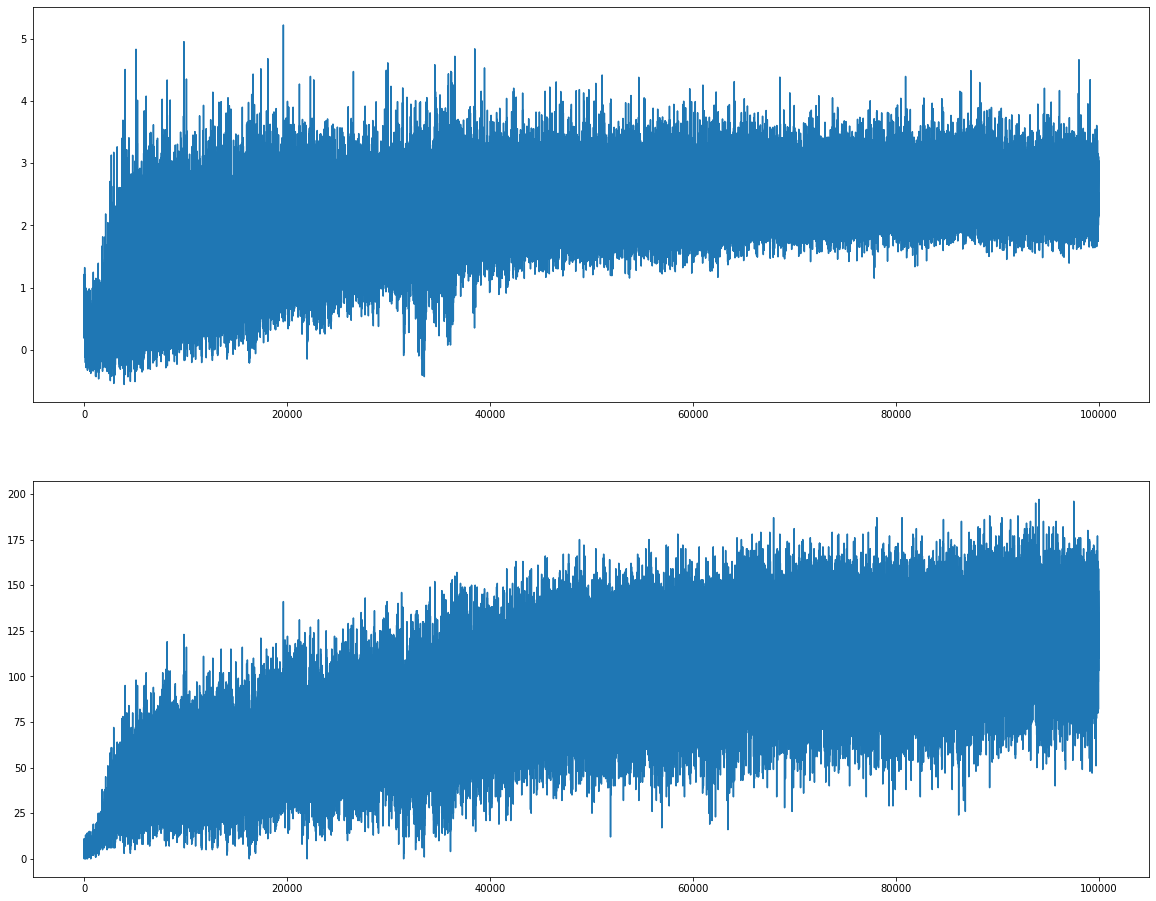

In [10]:
savepath='saved/Final'+params['net_type']+'.pt'
results = torch.load(savepath)
stats = results['stats_dict']

# plot loss over time
plt.subplot(2,1,1)
x = np.arange(params['num_episodes'])
loss = stats['losses_objective']
#y_NM = NM_stats['losses_objective']
#y_SM = SM_stats['losses_objective']
#y_RM = RM_stats['losses_objective']
plt.plot(x,loss)
# plt.plot(x,y_NM)
#plt.plot(x,y_SM)
#plt.plot(x,y_RM)

# plot rewards over time
plt.subplot(2,1,2)
rewards = stats['total_rewards']
# y_NM = NM_stats['total_rewards']
#y_SM = SM_stats['total_rewards']
#y_RM = RM_stats['total_rewards']
plt.plot(x,rewards)
# plt.plot(x,y_NM)
#plt.plot(x,y_SM)
#plt.plot(x,y_RM)
plt.show()

In [0]:
# save location
'''SAVE_FOLDER = "saved/experiment_1/"

# save
a_file = open(SAVE_FOLDER + params['net_type'] + "_stats.pkl", "wb")
pickle.dump(RM_stats, a_file) ## CHANGE THIS ACCORDINGLY
a_file.close()

alter_params_for_save()
a_file = open(SAVE_FOLDER + params['net_type'] + "_params.pkl", "wb")
pickle.dump(params, a_file) 
a_file.close()

torch.save(RM_model.state_dict(), SAVE_FOLDER + params['net_type'] + "_model.pt") ## THIS AS WELL'''

**Experiment 2: Hyperparameter Tuning**

Here we try to tune the most important hyperparameters so we achieve good performance on the best network, the retro modulated RNN (as shown by `experiment 1`).

We tune the following:
1. 
2. 
3.


**Experiment 3: Different Types of Networks (repeated)**

We must repeat `experiment 1` now with hyperparameters set to the best values found in `experiment 2` to confirm the findings of the first experiment. 

Again, only the parameter `net_type` is changed here.


**Experiment 4: Different Degrees Of Neuromodulation**

Here we observe the effect of full-modulation versus half modulation with respect to reward accumulated by a Retroactive Modulated RNN and a Simple Modulated RNN.

Only the parameter `

**Experiment 5: Different Number Of Neuromodulation Neurons** 

**Experiment 6: Different Activation Functions for Neuromodulation Neurons** 

### Results

We can see...